In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire
import wrangle
from scipy import stats
import sklearn.preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score



In [4]:
df = acquire.get_zillow_data()

Reading from csv file...


In [5]:
df_prep = df.copy(deep=True)

In [6]:
bed_bath_0_columns = ['bedroomcnt', 'bathroomcnt']
df_prep[bed_bath_0_columns] = df_prep[bed_bath_0_columns].replace(0, np.NaN)

df_prep = df_prep.dropna(subset=['bedroomcnt', 'bathroomcnt'], axis=0)
df_prep.reset_index(drop=True)

,id,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,propertylandusetypeid
0,20,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0,261.0
1,31,3.0,4.0,1620.0,847770.0,2011.0,10244.94,6037.0,261.0
2,33,3.0,2.0,2077.0,646760.0,1926.0,7924.68,6037.0,261.0
3,110,3.0,1.0,1244.0,169471.0,1950.0,2532.88,6037.0,261.0
4,111,3.0,2.0,1300.0,233266.0,1950.0,3110.99,6037.0,261.0
...,...,...,...,...,...,...,...,...,...
2138721,2982265,4.0,4.0,4375.0,422400.0,2015.0,13877.56,6037.0,261.0
2138722,2982268,4.0,3.0,2262.0,960756.0,2015.0,13494.52,6059.0,261.0
2138723,2982270,4.0,4.5,3127.0,536061.0,2014.0,6244.16,6059.0,261.0
2138724,2982275,3.0,2.5,1974.0,424353.0,2015.0,5302.70,6059.0,261.0


In [7]:
df_prep.isnull().sum()

id                                 0
bedroomcnt                         0
bathroomcnt                        0
calculatedfinishedsquarefeet     211
taxvaluedollarcnt                107
yearbuilt                       1250
taxamount                       2490
fips                               0
propertylandusetypeid              0
dtype: int64

In [12]:
df_impute = df_prep.copy(deep=True)

In [13]:
cols_to_impute = ['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt', 'taxamount']

In [43]:
X_full = df_impute.to_numpy()
y_full = df_impute[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'yearbuilt', 'taxamount']].to_numpy()

In [40]:
y_full

array([[  3633.  , 296425.  ,   2005.  ,   6941.39],
       [  1620.  , 847770.  ,   2011.  ,  10244.94],
       [  2077.  , 646760.  ,   1926.  ,   7924.68],
       ...,
       [  3127.  , 536061.  ,   2014.  ,   6244.16],
       [  1974.  , 424353.  ,   2015.  ,   5302.7 ],
       [  2110.  , 554009.  ,   2014.  ,   6761.2 ]])

In [44]:
def imputer_scores(X_full):
    br_estimator = BayesianRidge()
    score_simple_imputer = pd.DataFrame()
    for strategy in ("mean", "median"):
        estimator = make_pipeline(
            SimpleImputer(missing_values=np.nan, strategy=strategy), br_estimator)
    
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_full, scoring="neg_mean_squared_error", cv=5)

    # Estimate the score after iterative imputation of the missing values
    # with different estimators
    estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features="sqrt", random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15),
    ]
    score_iterative_imputer = pd.DataFrame()
    for impute_estimator in estimators:
        estimator = make_pipeline(
            IterativeImputer(random_state=0, estimator=impute_estimator), br_estimator)

    score_iterative_imputer[impute_estimator.__class__.__name__] = cross_val_score(
        estimator, X_full, scoring="neg_mean_squared_error", cv=5)

    scores = pd.concat(
        [score_simple_imputer, score_iterative_imputer],
        keys=["SimpleImputer", "IterativeImputer"],
        axis=1)

    # plot california housing results
    fig, ax = plt.subplots(figsize=(13, 6))
    means = -scores.mean()
    errors = scores.std()
    means.plot.barh(xerr=errors, ax=ax)
    ax.set_title("Zillow Regression with Different Imputation Methods")
    ax.set_xlabel("MSE (smaller is better)")
    ax.set_yticks(np.arange(means.shape[0]))
    ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
    plt.tight_layout(pad=1)
    plt.show()

In [45]:
imputer_scores(X_full)

/opt/homebrew/Caskroom/miniforge/base/envs/codeup/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/codeup/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 678, in _fit_and_score
    estimator.fit(X_train, **fit_params)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/codeup/lib/python3.9/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/homebrew/Caskroom/miniforge/base/envs/codeup/lib/pyth

KeyboardInterrupt: 

In [8]:
preprocessor = SimpleImputer(missing_values=np.nan, strategy='median')

preprocessor.fit(train[['yearbuilt']])

train[['yearbuilt']] = preprocessor.transform(train[['yearbuilt']])
validate[['yearbuilt']] = preprocessor.transform(validate[['yearbuilt']])
test[['yearbuilt']] = preprocessor.transform(test[['yearbuilt']])

preprocessor_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

preprocessor_mean.fit(train[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount']])

train[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount']] = preprocessor_mean.transform(train[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount']])
validate[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount']] = preprocessor_mean.transform(validate[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount']])
test[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount']] = preprocessor_mean.transform(test[['calculatedfinishedsquarefeet', 'taxvaluedollarcnt', 'taxamount']])

Descriptive Stats:


,count,mean,std,min,25%,50%,75%,max
id,1197686.0,1.491059e+06,860936.056513,20.00,745539.5,1490384.50,2236521.500,2982282.0
bedroomcnt,1197686.0,3.307509e+00,0.921539,1.00,3.0,3.00,4.000,25.0
bathroomcnt,1197686.0,2.244498e+00,0.986640,0.50,2.0,2.00,3.000,32.0
calculatedfinishedsquarefeet,1197686.0,1.863152e+03,962.814229,1.00,1259.0,1624.00,2208.000,39170.0
taxvaluedollarcnt,1197686.0,4.606958e+05,678464.879837,18.00,189230.5,328341.50,534763.500,88020448.0
yearbuilt,1197686.0,1.960973e+03,22.133877,1801.00,1949.0,1958.00,1975.000,2016.0
taxamount,1197686.0,5.616566e+03,7802.113424,17.66,2545.4,4117.06,6409.215,1052070.5
fips,1197686.0,6.048305e+03,20.334926,6037.00,6037.0,6037.00,6059.000,6111.0
propertylandusetypeid,1197686.0,2.610000e+02,0.000000,261.00,261.0,261.00,261.000,261.0


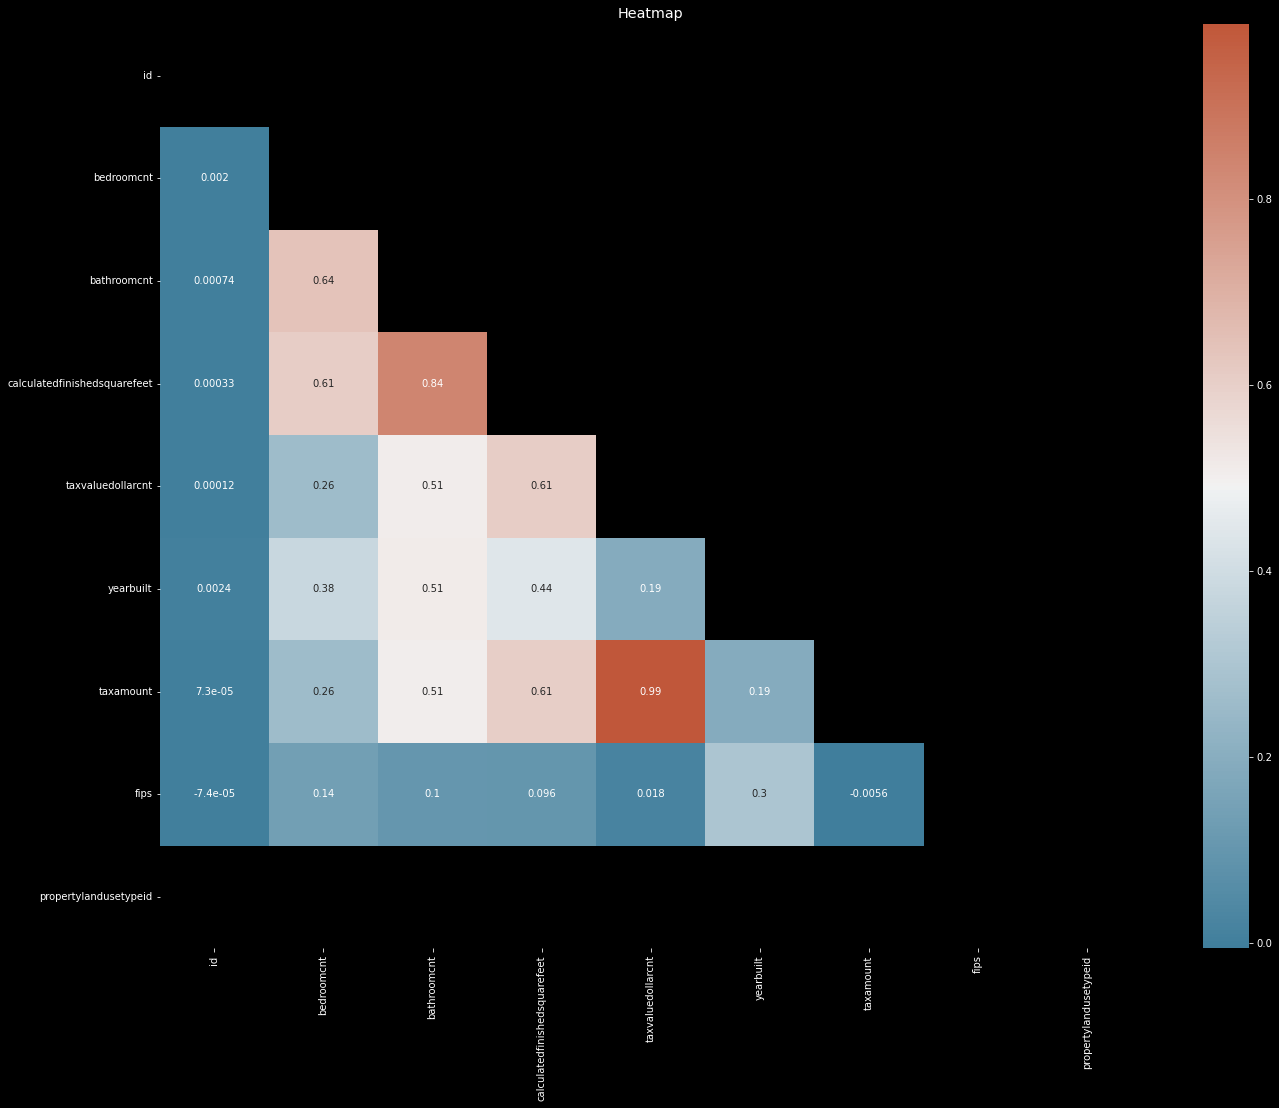

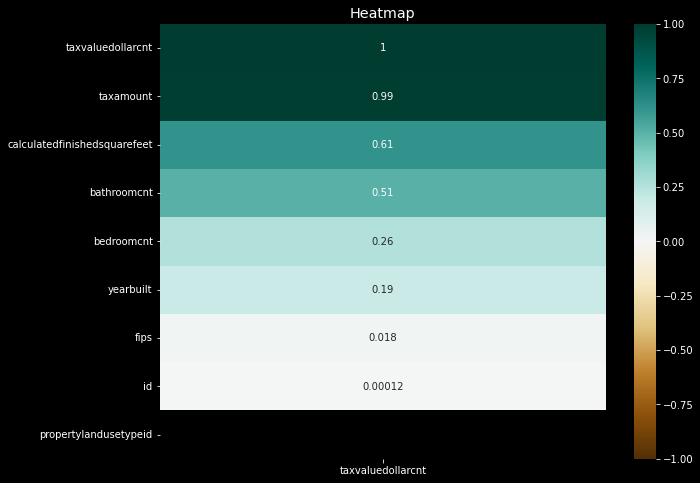

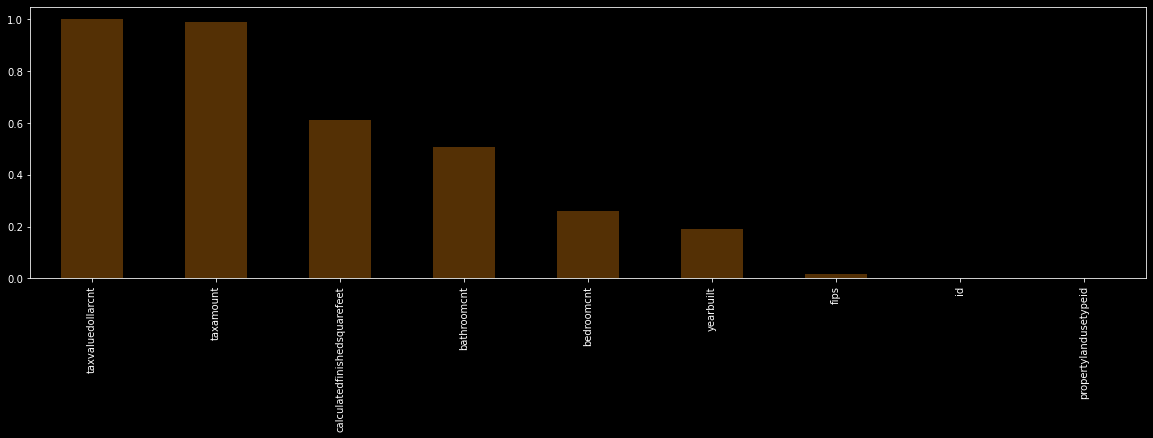

In [9]:
wrangle.corrstatsgraphs(train)

In [ ]:

plt.figure(figsize=(18, 3))

# List of columns
cols = [col for col in df_prep.columns if col not in ['propertylandusetypeid','id','fips', 'year_built']]

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1, len(cols), plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    df[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)
    
    # turn off scientific notation
    plt.ticklabel_format(useOffset=False)
    
plt.show()

In [10]:
train.isnull().sum()

id                              0
bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
taxamount                       0
fips                            0
propertylandusetypeid           0
dtype: int64

In [11]:
validate.isnull().sum()

id                              0
bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
taxamount                       0
fips                            0
propertylandusetypeid           0
dtype: int64

In [12]:
test.isnull().sum()

id                              0
bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
taxamount                       0
fips                            0
propertylandusetypeid           0
dtype: int64

In [33]:
df_scale = df_impute.copy(deep=True)

In [18]:
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.X_y(train, validate, test)

Text(0.5, 1.0, 'Scaled')

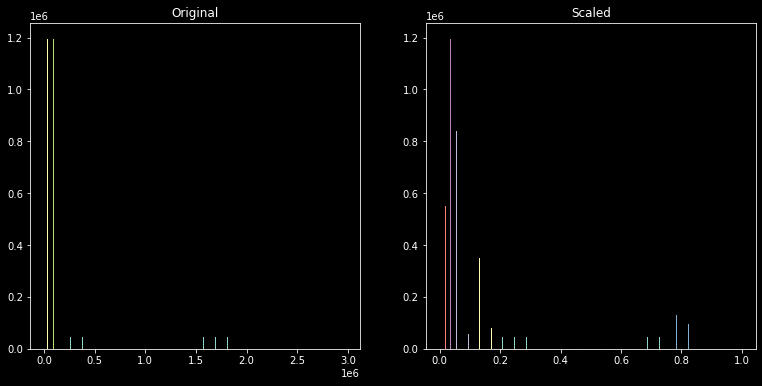

In [14]:
scaler = sklearn.preprocessing.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train)

x_train_scaled = scaler.transform(X_train)
x_validate_scaled = scaler.transform(X_validate)
x_test_scaled = scaler.transform(X_test)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.title('Scaled')


Text(0.5, 1.0, 'Scaled')

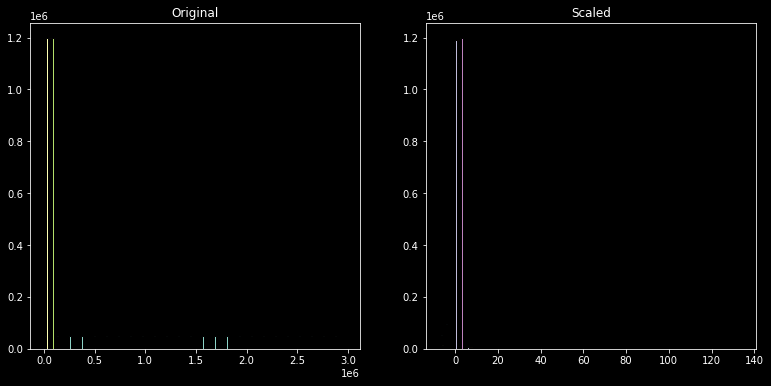

In [17]:
scaler = sklearn.preprocessing.StandardScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train)

x_train_scaled = scaler.transform(X_train)
x_validate_scaled = scaler.transform(X_validate)
x_test_scaled = scaler.transform(X_test)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.title('Scaled')


Text(0.5, 1.0, 'Scaled')

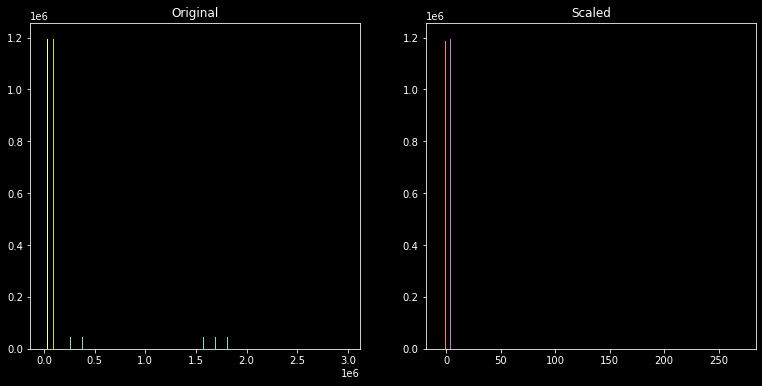

In [19]:
scaler = sklearn.preprocessing.RobustScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train)

x_train_scaled = scaler.transform(X_train)
x_validate_scaled = scaler.transform(X_validate)
x_test_scaled = scaler.transform(X_test)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(x_train_scaled, bins=25, ec='black')
plt.title('Scaled')
